<a href="https://colab.research.google.com/github/LinaTobon/SegmentacionEmpleados/blob/main/SegmentacionEmpleados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lina María Tobón R.🐕



##Analisis informacion de ventas y presupuesto febrero - julio 2021

### Carga de informacion

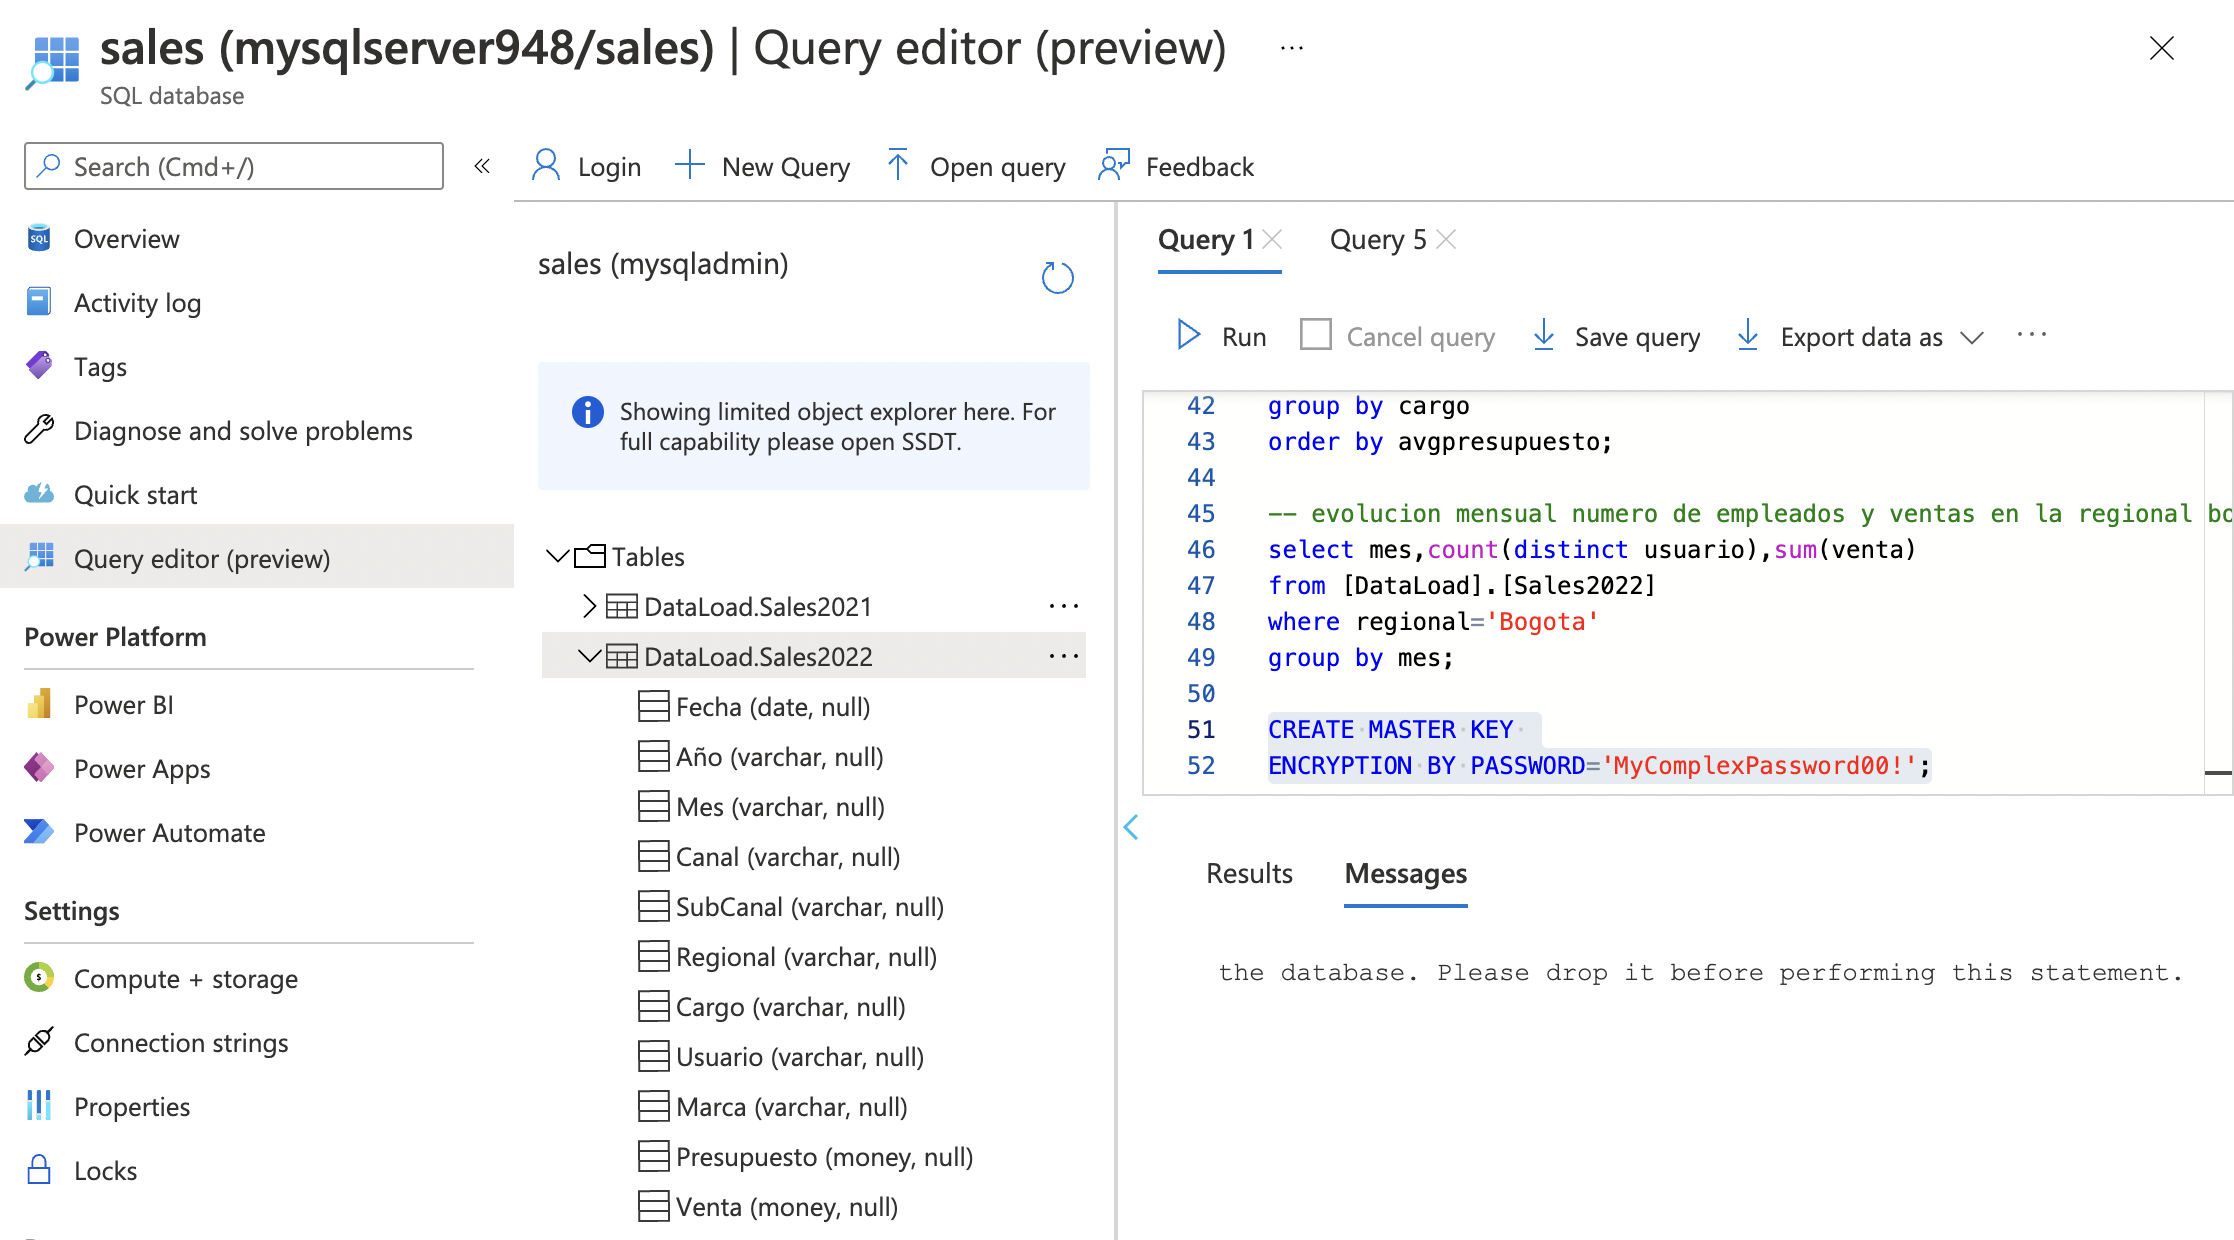

In [ ]:
from PIL import Image
im = Image.open('/content/drive/MyDrive/ColabNotebooks/PruebaGluky/BDAzure.png')
im.show()
display(im)

El csv caso_analista_bi.csv se cargó a una SQL Database en Azure siguiendo los siguientes pasos en Azure:

1.   Creación de storage account en Azure, usando un blob container
2.   Creación de Shared Access Signature para el  storage account
3.   Carga de csv en container

A continuación se detallan los pasos y lineas de codigo corridas en Data Studio:





In [ ]:
#Creación de tabla y esquema en la base de datos, donde se almacenará la informaciòn (linea de codigo corrida en Data Studio)

IF SCHEMA_ID('DataLoad') IS NULL 
EXEC ('CREATE SCHEMA DataLoad')

CREATE TABLE DataLoad.Sales2022
(
    Fecha       date,
    Año         varchar(10),
    Mes         varchar(10),
    Canal       varchar(50),
    SubCanal    varchar(50),
    Regional    varchar(50),
    Cargo       varchar(50),
    Usuario     varchar(50),
    Marca       varchar(50),
    Presupuesto money,
    Venta       money,
) 

In [ ]:
# creacion master key
CREATE MASTER KEY 
ENCRYPTION BY PASSWORD='MyComplexPassword00!';

In [ ]:
# Create a DATABASE SCOPED CREDENTIAL
# Esta credencial esta asociadad a la  Azure blob storage account 

CREATE DATABASE SCOPED CREDENTIAL test
WITH IDENTITY = 'SHARED ACCESS SIGNATURE',
SECRET = 'sp=racwdl&st=2021-12-01T20:17:33Z&se=2021-12-02T04:17:33Z&spr=https&sv=2020-08-04&sr=c&sig=1sxqqkNqqjtWBi1XTiKBZLd7i%2BP4CB1EfsmqfQQVMbs%3D';


In [ ]:
# creacion de fuente de datos externa al container
CREATE EXTERNAL DATA SOURCE dataframe
WITH 
(
    TYPE = BLOB_STORAGE,
    LOCATION = 'https://sqlva3iw7mjlerefxq.blob.core.windows.net/source',
    CREDENTIAL = test
);

In [ ]:
#insertar informacion desde csv a  la tabla con BULK INSERT
SET NOCOUNT ON -- Reduce network traffic by stopping the message that shows the number of rows affected
 BULK INSERT DataLoad.Sales2022 -- Table you created in Step 1
 FROM 'caso_analista.csv' -- Within the container, the location of the file
     WITH (
			DATA_SOURCE = 'dataframe' -- Using the External data source from Step 4
			,DATAFILETYPE = 'char' 
	        ,FIELDTERMINATOR = ',' 
	        ,ROWTERMINATOR = '0x0a'
            ,FIRSTROW=2 
            ,BATCHSIZE=100000 -- Reduce network traffic by inserting in batches
            , TABLOCK -- Minimize number of log records for the insert operation
           )

In [ ]:
# carga de librerias
import pandas as pd
import numpy as np

In [ ]:
sales2021 = pd.read_excel("/content/drive/MyDrive/ColabNotebooks/PruebaGluky/CASO ANALISTA BI 2021.xlsx")

In [ ]:
# informacion de campos y tipos de datos
sales2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31597 entries, 0 to 31596
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fecha         31597 non-null  object 
 1   Año           31597 non-null  int64  
 2   Mes           31597 non-null  object 
 3   Canal         31597 non-null  object 
 4   SubCanal      31597 non-null  object 
 5   Regional      31597 non-null  object 
 6   Cargo         31597 non-null  object 
 7   Usuario       31597 non-null  int64  
 8   Marca         31597 non-null  object 
 9   Presupuesto   31597 non-null  float64
 10  cumplimiento  31597 non-null  object 
 11  Venta         31597 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 2.9+ MB


**Hallazgos**


*   Los tipos de datos son adecuados segun la informacion contenida en los campos
*   No hay campos con registros nulos



### Análisis exploratorio y limpieza de datos

[DASHBOARD](https://app.powerbi.com/view?r=eyJrIjoiNzJhNWI5ZDgtMGVkYS00OTRiLTg2NTktYzQ4Nzg1ZDM5YTUxIiwidCI6IjU3N2ZjMWQ4LTA5MjItNDU4ZS04N2JmLWVjNGY0NTVlYjYwMCIsImMiOjR9&pageName=ReportSection29b8a9e78e1cc9b5b61b)

#### Unicidad de Usuarios

In [ ]:
df = sales2021.groupby(['Usuario','Mes','Marca','Canal','SubCanal']).agg({'Usuario':'count'},as_index=False)
df.rename(columns={'Usuario':'Conteo'},inplace=True)


In [ ]:
df.sort_values(by='Conteo',ascending=False)

Conteo
Usuario Mes     Marca      Canal          SubCanal                        
1024    Febrero Dulces     Minorista      Minorista Distribuidores       6
2636    Junio   Dulces     Minorista      Minorista Distribuidores       4
1825    Febrero Dulces     Minorista      Minorista Distribuidores       4
8482    Marzo   Bebidas    Tiendas Mixtas Mixtas                         4
        Julio   Importados Tiendas Mixtas Mixtas                         4
...                                                                    ...
3685    Abril   Importados Tiendas Mixtas Mixtas                         1
                Dulces     Tiendas Mixtas Mixtas                         1
                Bebidas    Tiendas Mixtas Mixtas                         1
3683    Mayo    Procesados Minorista      Minorista Tradicional          1
9997    Mayo    Procesados Tiendas Mixtas Efectivo                       1

[25542 rows x 1 columns]

**Hallazgos**


*   Existen varios registros por usuario por mes, por lo tanto se debe consultar con area de negocio, el por qué un empleado podría tener diferentes ventas y metas en el mismo mes por la misma marca,canal y Subcanal. Por motivos del ejercicio estos valores se agregarán.

#### Niveles de variables categòricas

In [ ]:
# variable colums contiene los nombres de los campos de la tabla sales2021
columns = sales2021.columns

# division de columnas por tipo de datos
categorical = [col for col in columns if sales2021.dtypes[col]==np.object]
numerical = [col for col in columns if sales2021.dtypes[col]==np.int64 or sales2021.dtypes[col]==np.float64]

# imprime el nombre de las variables categóricas, el numero de niveles unicos y la frecuencia por nivel
for i in categorical:
  print('variable:'+str(i)+'-','Niveles:'+str(sales2021[i].nunique()),sep='')
  print(sales2021[i].value_counts(),"\n")

variable:Fecha-Niveles:6
2021-03-01    7862
2021-07-01    5266
2021-02-01    4992
2021-06-01    4619
2021-05-01    4492
2021-04-01    4366
Name: Fecha, dtype: int64 

variable:Mes-Niveles:6
Marzo      7862
Julio      5266
Febrero    4992
Junio      4619
Mayo       4492
Abril      4366
Name: Mes, dtype: int64 

variable:Canal-Niveles:6
Minorista                  18595
Tiendas Mixtas              8111
Mini-Merca                  4326
Farmacia                     385
Mercados independientes      115
Tienda                        65
Name: Canal, dtype: int64 

variable:SubCanal-Niveles:13
Minorista Distribuidores    13666
Mixtas                       7957
Minorista Tradicional        2700
Mercado                      2290
Ds                           2229
Sup Supermdo Indepen         2024
Droga                         385
Mercados                       86
Efectivo                       83
Variedades                     71
Tienda M                       65
Mercados-indepen               29


**Hallazgos**


*   Se dispone información desde febrero hasta julio de 2021
*   En la variable Canal existe el nivel Mercado y Mercados, se debe unificar
*   Es necesario unificar los nombres de las regionales, ya que existen casos como Medellín y Medellin, los cuales hacen referencia a una sola regional
*  Hay espacios en blanco en la variable regional y cargo
*  Definir si las regionales centro,oriente, costa, nacional son agregaciones de otras regionales; ya que estariamos duplicando informacion si es el caso 



### Limpieza de datos

##### 1. Unificacion de niveles de las variables categoricas

In [ ]:
# unificacion de niveles variables  Regional y Canal
sales2021['Regional'].replace('Medellín','Medellin',inplace=True)
sales2021['Regional'].replace(['Ibagué','ibague'],'Ibague',inplace=True)
sales2021['Canal'].replace('Mercados','Mercado',inplace=True)
sales2021['Cargo'].replace('comercial','Comercial',inplace=True)

##### 2. Limpieza de espacios en blanco

In [ ]:
# funcion para remover espacios dentro del campo
def remove_blanks(variable):
  sales2021[variable] = sales2021[variable].str.strip()

In [ ]:
# se aplica la funcion remove_blanks a todas las variables categoricas
for i in categorical:
  remove_blanks(i)

In [ ]:
sales2021['Regional'].value_counts()

Bogota           9201
Cali             4375
Bucaramanga      3663
Medellin         3372
Barranquilla     3041
Ibague           2815
Galapa           1938
Pereira          1664
Centro            490
Antioquia         423
Sur Occidente     393
Oriente           197
Costa              13
Nacional           12
Name: Regional, dtype: int64

In [ ]:
sales2021['Cargo'].value_counts()

Asesor                 27923
Supervisor              1060
Lider                    676
Mercaderista             516
Gerente                  465
Transferencista          291
Contador                 194
Comercial                183
Independientes            78
Conector                  56
Super                     46
Desarrollador             41
Tecnico                   34
Jefe                      16
Drogueria                 15
Tecnico/Practicante        3
Name: Cargo, dtype: int64

In [ ]:
# guarda dataframe como csv
sales2021.to_csv("caso_analistas.csv",index=False)

#### Coordenadas por regional. Nota: Esta seccion finalmente no fue utilizada para el dashboard

In [ ]:
from geopy.geocoders import Nominatim,GeoNames

In [ ]:
# funcion para obtener coordenadas de las regionales
def get_coords(city):
  gn = GeoNames(username='lmtobonr')
  if city=='Centro':
    city = 'Meta'
  elif city =='Oriente':
    city = 'Santander'
  elif city == 'Sur Occidente':
    city = 'Putumayo'
  elif city == 'Costa':
    city='Cesar'
  elif city == 'Nacional':
    city='Cundinamarca'

  location = gn.geocode(city)
  if location is not None:
    latitude = location.latitude
    longitude = location.longitude
  else:
      latitude = longitude = np.NaN
  return pd.Series({"Latitud": latitude, "Longitude": longitude})


In [ ]:
# prueba de la funcion para Bogotá
get_coords('Bogota')

Latitud       4.60971
Longitude   -74.08175
dtype: float64

In [ ]:
# se obtiene dataframe geolocalization
df = pd.DataFrame(sales2021.Regional.unique(),columns=['Regional'])
geolocalization = pd.concat([df, df.Regional.apply(get_coords)], axis=1)

In [ ]:
geolocalization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Regional   14 non-null     object 
 1   Latitud    14 non-null     float64
 2   Longitude  14 non-null     float64
dtypes: float64(2), object(1)
memory usage: 464.0+ bytes


In [ ]:
# se guarda el dataframe como csv
geolocalization.to_csv("geolocalizacion.csv",index=False)

## Segmentación de empleados

Para realizar la segmentación de empleados se seguirán los siguientes pasos


1. **Preparación de datos:**  
Se deben transformar los datos de manera que cada registro represente un unico usuario o empleado actual de la compañía, de manera que solo nos quedaremos con los empleados de todas las regionales que cuentan con información para el mes de julio.


2.  **Generación de caracteristicas:** 
Se generarán las siguientes características por empelado:
*   Ventas totales por marca
*   Ventas totales por canal
*   Mediana del cumplimiento
*   Cumplimiento por canal
*   Numero de canales, marcas y regionales asignados
*   Seniority : antiguedad del empleado


3.  **Implementación de segmentación con método kmeans:**

*   Re-escalamiento de variables numéricas
*   Hallar Número óptimo de clústeres con el metodo elbow
*   Implementación del metodo  KMeans

5. **Visualización de clusters**

6. **Implementación de segmentación con método de puntajes basado en quartiles**

7. **Conclusiones**









### Preparación de datos

In [ ]:
# se crea tabla con empleados al mes de julio
empl_jul = pd.DataFrame(sales2021.query("Mes== 'Julio'")['Usuario'].unique(),columns=['Usuario'])

In [ ]:
empl_jul.shape

(1206, 1)

Para el mes de Julio la compañía cuenta con 1206 colaboradores. 

### Generación de caracteristicas

#### Caracteristicas a partir del cumplimiento de metas

In [ ]:
# se crea la variable cumplimiento como la division de las ventas sobre el presupuesto

sales2021['Cumplimiento'] = round(np.divide(sales2021['Venta'], sales2021['Presupuesto'],\
                            out=np.zeros_like(sales2021['Venta']), where=sales2021['Presupuesto']!=0),2)


In [ ]:
# se crea la variable cumplimiento canal como la mediana del cumplimiento del empleado, se escoge mediana como medida poco sensible a outliers

cumplimiento_canal = sales2021.pivot_table(index='Usuario',values='Cumplimiento',columns='Canal',\
                                           aggfunc={'Cumplimiento':'median'},fill_value=0)

In [ ]:
# se crea la variable cumplimiento_median como la mediana del cumplimiento del empleado

cumplimiento_median = sales2021.pivot_table(index='Usuario',values='Cumplimiento',\
                                            aggfunc={'Cumplimiento':'median'},fill_value=0)

#### Caracteristicas a partir de las ventas

In [ ]:
# se crea la variable aggventa_marca como la mediana de las ventas del empleado por marca, se escoge mediana como medida poco sensible a outliers

aggventa_marca = sales2021.pivot_table(index='Usuario',values='Venta',columns='Marca', \
                                       aggfunc={'Venta':'median'},fill_value=0)

In [ ]:
# se crea la variable aggventa_canal como la mediana de las ventas del empleado por canal, se escoge mediana como medida poco sensible a outl

aggventa_canal = sales2021.pivot_table(index='Usuario',values='Venta',columns='Canal', \
                                       aggfunc={'Venta':'median'},fill_value=0)

#### Caracteristicas a partir del conteo de meses, marcas, regionales y canales

In [ ]:
# se crea la variable seniority como la cuenta de los meses donde se tiene registro del empleado

seniority = sales2021.groupby(['Usuario']).agg({'Mes':'nunique'},as_index=False)

In [ ]:
# se crea la variable polivalencia como el numero de marcas,canales y regiones que ha atendido el usuario

polivalencia = sales2021.groupby(['Usuario']).agg({'Marca':'nunique','Canal':'nunique','Regional':'nunique'},as_index=False)
polivalencia.reset_index(inplace=True)

# se renombran columnas
polivalencia.rename(columns={'Marca':'num_marca','Canal':'num_canal','Regional':'num_regional'},inplace=True)

In [ ]:
# funcion para renombrar columnas y eliminar multi index proveniente del pivot

bases_agregadas = [cumplimiento_canal,aggventa_marca,aggventa_canal]

def rename_columns(bases):
  for df in bases:
    df.columns = [''.join(col).strip() for col in df.columns.values]
  return df

In [ ]:
rename_columns(bases_agregadas)


,Farmacia,Mercados independientes,Mini-Merca,Minorista,Tienda,Tiendas Mixtas
Usuario,,,,,,
9,0.0,0.0,0.00,1939456.48,0.0,0.00
10,0.0,0.0,0.00,4236071.58,0.0,0.00
11,0.0,0.0,7515207.44,0.00,0.0,0.00
13,0.0,0.0,0.00,3153334.60,0.0,7956005.72
47,0.0,0.0,0.00,2261330.50,0.0,0.00
...,...,...,...,...,...,...
9988,0.0,0.0,0.00,0.00,0.0,1576531.32
9991,0.0,0.0,0.00,1158706.12,0.0,0.00
9992,0.0,0.0,0.00,3509727.26,0.0,0.00


#### Union de bases

In [ ]:
from functools import reduce

In [ ]:
# union de dataframes con base en el usuario
dataframes = [cumplimiento_median,aggventa_marca,aggventa_canal,\
              seniority, polivalencia,empl_jul]
empleados = reduce(lambda  left,right: pd.merge(left,right,on=['Usuario'],
                                            how='inner'), dataframes)

In [ ]:
# se indexa por usuario
empleados.set_index('Usuario',inplace=True)

# verificacion de las dimensiones del dataset
empleados.shape

(1206, 17)

Nuestra base de empleados consiste en 1206 empleados activos a julio, con 17 caracteristicas

### Seleccion de caracteristicas

Para seleccionar las caracteristicas que se tendrán en cuenta en el modelo, filtraremos las variables con mayor variablidad, según su rango intercuartílico. 

In [ ]:
def var_selection(df):

  # selecciona variables del dataframe (df) con mayor IQR
  stats = df.describe().T
  stats.reset_index(inplace=True)
  stats.set_index('index',inplace=True)
  stats['IQR'] = stats['75%']-stats['25%']
  selected_vars = list(stats.query("IQR > 0.01").index)
  
  return selected_vars

In [ ]:
selected_vars = var_selection(empleados)

In [ ]:
selected_vars 

['Cumplimiento',
 'Bebidas',
 'Chocolates',
 'Dulces',
 'Gomitas',
 'Importados',
 'Procesados',
 'Minorista',
 'Tiendas Mixtas',
 'num_marca',
 'num_regional']

### Implementación de segmentacion con metodo Kmeans

#### Re escalemiento de variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# se crea el dataframe train con las variables seleccionadas

train = empleados[selected_vars]

In [ ]:
# se re escalan las variables con el método MinMax scaler
scaler = MinMaxScaler()

train[selected_vars] = scaler.fit_transform(empleados[selected_vars])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Cumplimiento,1206.0,0.472960,0.070033,0.0,0.445087,0.476879,0.508671,1.0
Bebidas,1206.0,0.016552,0.057237,0.0,0.002790,0.005139,0.009260,1.0
Chocolates,1206.0,0.008809,0.039626,0.0,0.001311,0.002208,0.003632,1.0
Dulces,1206.0,0.027386,0.075473,0.0,0.006002,0.009306,0.014628,1.0
Gomitas,1206.0,0.009928,0.051122,0.0,0.000982,0.002423,0.004089,1.0
Importados,1206.0,0.010809,0.044097,0.0,0.001761,0.003113,0.004899,1.0
Procesados,1206.0,0.017030,0.072901,0.0,0.000042,0.001667,0.007874,1.0
Minorista,1206.0,0.013576,0.058110,0.0,0.000000,0.003033,0.006228,1.0
Tiendas Mixtas,1206.0,0.013143,0.064092,0.0,0.000000,0.000000,0.009760,1.0
num_marca,1206.0,0.894196,0.146493,0.0,0.800000,1.000000,1.000000,1.0


#### Elbow method numero optimo de clusters

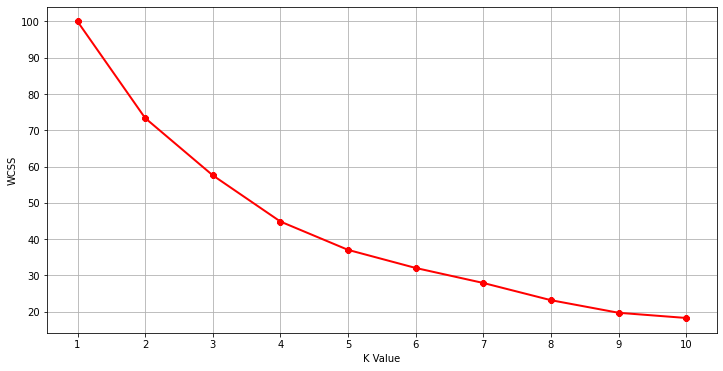

In [ ]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(train)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

En el valor de k=4, donde se observa el maximo decrecimiento de la mejora de la  incercia . 

In [ ]:
# implementacion del metodo k means

km = KMeans(n_clusters=4)
clusters = km.fit_predict(train)
train["cluster"] = clusters


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# se obtiene el numero de empleados por cluster

pd.DataFrame(list(train.cluster.value_counts()), columns = ['numero empleados'])

,numero empleados
0,443
1,381
2,309
3,73


In [ ]:
# promedio de carateristicas por cluster
train.groupby('cluster').mean()

,Cumplimiento,Bebidas,Chocolates,Dulces,Gomitas,Importados,Procesados,Minorista,Tiendas Mixtas,num_marca,num_regional
cluster,,,,,,,,,,,
0,0.471072,0.026160,0.014680,0.037981,0.019324,0.016992,0.022787,0.022977,0.014839,0.918736,0.243228
1,0.486209,0.012133,0.003586,0.021035,0.005066,0.004887,0.020870,0.002866,0.019569,1.000000,0.000000
2,0.462016,0.008599,0.006390,0.023092,0.002408,0.009146,0.004446,0.012254,0.000359,0.717799,0.008091
3,0.461596,0.014980,0.010679,0.014418,0.010124,0.011236,0.015319,0.018022,0.023426,0.939726,0.585616


Como resultado del ejercicio obtenemos 4 clusters.

Cluster 0: 
* Tienen muy buenas ventas en todos los segmentos 
* Su canal de ventas mas efectivo es las Minoristas.
* No atienden gran variedad de marcas
* Algunos de ellos han estado en mas de una regional
* Buen cumplimiento de metas

Cluster 1:
* especialistas en venta de procesados, rendimiento promedio en los demas segmentos
* Su canal de ventas mas efectivo son las tiendas
* Manejan alta diversidad de segmentos
* Han estado en una sola regional
* Cumplimiento de metas superior

Cluster 2:
* especialistas en venta de dulces
* Su canal de ventas mas efectivo son las Minoristas
* No Manejan diversidad de segmentos
* Han estado en una sola regional
* Cumplimimiento de metas medio

Cluster 3:
* Tienen muy buenas ventas en todos los segmentos 
* Su canal de ventas mas efectivo son las tiendas.
* Manejan variedad de marcas
* Han estado en mas de una regional
* Cumplimiento de metas inferior



### Visualización

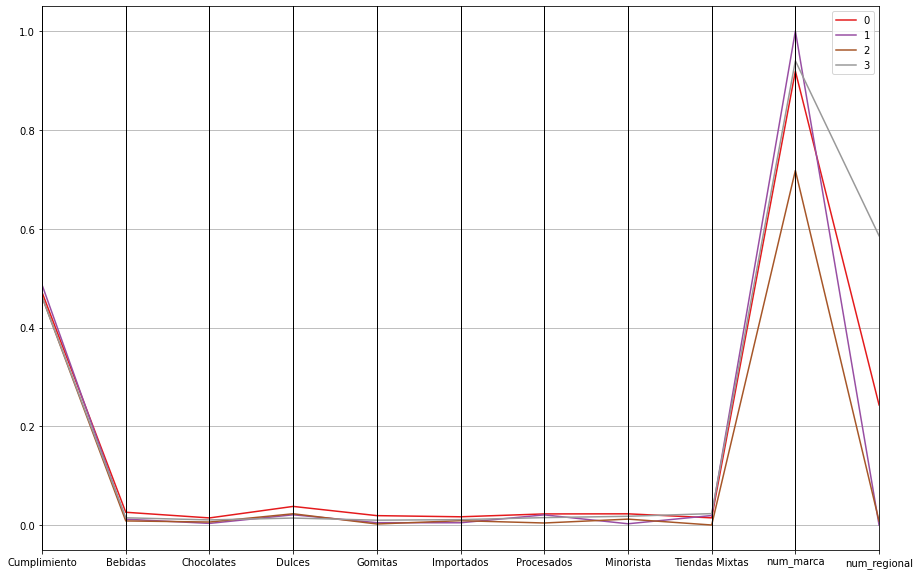

In [ ]:
# Create a data frame containing our centroids

centroides = pd.DataFrame(km.cluster_centers_, columns=train.columns)
centroides['cluster'] = centroides.index

#parallel_coordinates(centroides, 'cluster')

plt.figure(figsize=(15,10))
parallel_coordinates(centroides, 'cluster', colormap=plt.get_cmap("Set1"))
plt.show()


In [ ]:
import plotly.express as px

fig = px.parallel_coordinates(centroides, color="cluster",
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

## Implementacion de segmentacion con metodo de puntajes relativos basados en cuartiles

Los cuartiles son valores que dividen una muestra de datos en cuatro partes iguales. Los cuartiles dan una indicacion de la dispersión y la tendencia central de un conjunto de datos. Se utilizará esta metodología teniendo en cuenta las variables Mediana de Cumplimiento, ventas por usuario y seniority.

In [ ]:
# se crea la variable de ventas por usuario

ventas_usuario = sales2021.groupby(['Usuario']).agg({'Venta':'median'},as_index=False)

In [ ]:
# union de dataframes para obtener caracteristicas
 
dataframes = [cumplimiento_median,ventas_usuario,seniority]

cvs = reduce(lambda  left,right: pd.merge(left,right,on=['Usuario'],
                                            how='inner'), dataframes)


In [ ]:
cvs.head()

,Cumplimiento,Venta,Mes
Usuario,,,
9,0.955,1939456.48,6
10,0.840,4236071.58,2
11,0.940,7515207.44,6
13,1.005,7787460.20,6
47,0.820,2261330.50,5


In [ ]:
# division de datos en cuartiles
for i in cvs.columns:
  cvs[i+'Q']= pd.qcut(cvs[i].rank(method='first'), 4, ['1','2','3','4'])

In [ ]:
# conversion ed variables numericas a tipo string
cvs_cols = [col  for col in cvs.columns if col.endswith('Q') ]
for i in cvs_cols:
  cvs[i].map(str)

In [ ]:
# se obtiene el score con la concatenacion de resultados para cada una de las caterteristicas
cvs['CVScore']= cvs[cvs_cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [ ]:
# Observar numero de clients por cluster
cvs_clusters = cvs.groupby(['CVScore']).agg({'CVScore':'count'},as_index=False)
cvs_clusters.rename(columns={'CVScore':'count'},inplace=True)

In [ ]:
cvs_clusters.sort_values(by='count',ascending=False)

,count
CVScore,
111,71
441,58
112,48
334,47
433,46
...,...
412,15
143,13
414,10


In [ ]:
cvs.groupby(['MesQ']).agg({'CumplimientoQ':'count'},as_index=False)

,CumplimientoQ
MesQ,
1,449
2,448
3,448
4,448


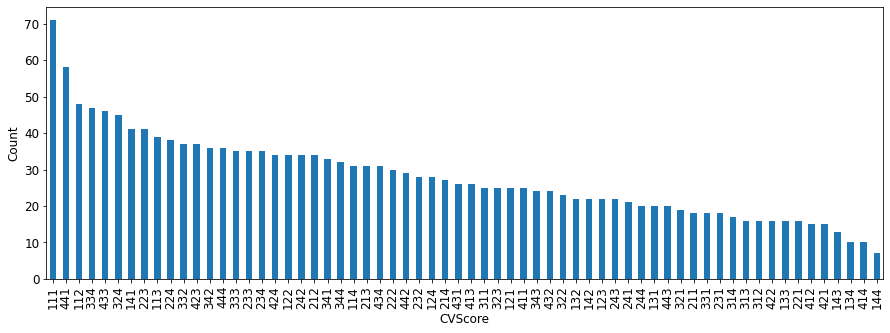

In [ ]:
ax = cvs['CVScore'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("CVScore", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

Con este metodo tenemos clusters muy uniformces en cuanto al numero de empleados. Lo que hace pensar que no es una buena estrategia de segmentacion respecto al kmeans anterior.
Sin embargo, nos permite sacar algunos insights:
* Podemos ver que nuestro mayor segmento está formado por empleados con los menores montos de ventas, menor cumplimiento y no mucha experiencia en la empresa. 
* Sin embargo, nuestro siguiente segmento más grande está formado por nuestros empleados más valiosos, quienes aunque son junior tienen altos niveles de ventas y cumplimiento.